# DQN Algorithm Practice

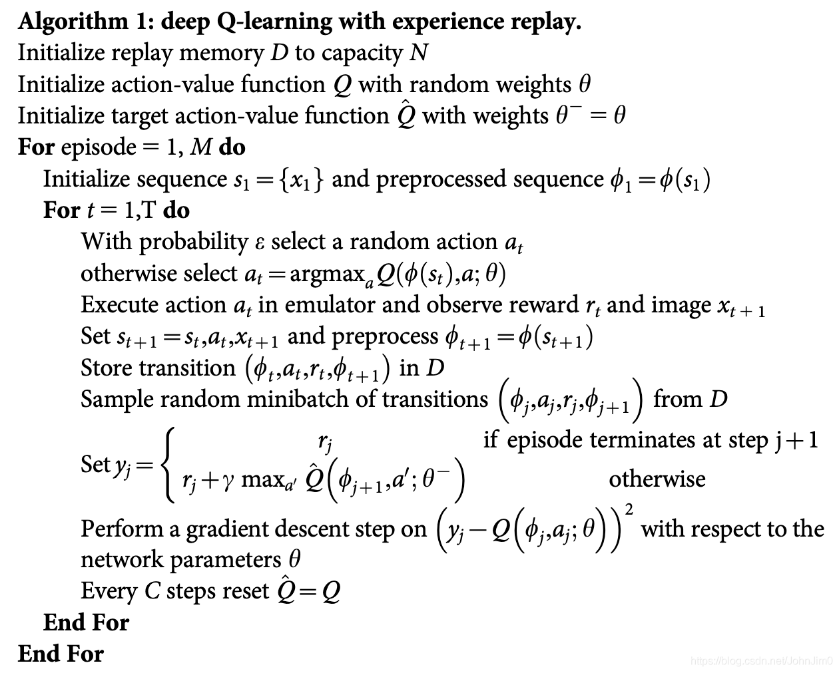

## Replay Buffer

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import numpy as np

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity # Capacity of the replay buffer
        self.buffer = [] # Replay buffer
        self.position = 0
        
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        # Insert the Data fraction
        self.position = (self.position+1) % self.capacity
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size) # Sampling data
        state, action, reward, next_state, done = zip(*batch) # make each columns as a list
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)


C:\Users\iDLaber\miniconda3\envs\baselines\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## DQN

In [2]:
class DQN:
    def __init__(self, n_actions, model, cfg):
        self.n_actions = n_actions # How many actions there are
        self.device = cfg.device # Setting: cpu or gpu
        self.gamma = cfg.gamma # Set the discounting factor
        
        # epsilon-greedy parameters
        self.frame_idx = 0 # 
        # epsilon value
        self.epsilon = lambda frame_idx: cfg.epsilon_end + \
                        (cfg.epsilon_start - cfg.epsilon_end) * \
                        math.exp(-1. * frame_idx / cfg.epsilon_decay)
        self.batch_size = cfg.batch_size
        self.policy_net = model.to(self.device)
        self.target_net = model.to(self.device)
        
        # copy original policy parameters into target policy parameters
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(param.data)
        
        # initialize optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr = cfg.lr)
        # initialize replay buffer
        self.memory = ReplayBuffer(cfg.memory_capacity)
    
    # choose action
    def choose_action(self,state):
        self.frame_idx += 1
        if random.random() > self.epsilon(self.frame_idx):
            with torch.no_grad():
                state = torch.tensor(state, device = self.device, dtype = torch.float32).unsqueeze(dim=0)
                q_values = self.policy_net(state)
                action = q_values.max(1)[1].item() # select the action maximizing q
        else:
            action = random.randrange(self.n_actions)
        return action
    
    # update
    def update(self):
        # 1. if the memory is not full -> not update
        if len(self.memory < self.batch_size):
            return
        
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(self.batch_size)
        state_batch = torch.tensor(np.array(state_batch), device = self.device, dtype = torch.float)
        action_batch = torch.tensor(action_batch, device = self.device).unsqueeze(1)
        reward_batch = torch.tensor(reward_batch, device = self.device, dtype=torch.float)
        next_state_batch = torch.tensor(np.array(next_state_batch), device = self.device, dtype = torch.float)
        done_batch = torch.tensor(np.float32(done_batch), device=self.device)
        
        # calculate the corresponding Q(s_t,a) with (s_t,a) - gather: extract the data in the index
        q_values = self.policy_net(state_batch).gather(dim=1, index=action_batch)
        # calculate the next state's Q : detach - unchanged target policy
        next_q_values = self.target_net(next_state_batch).max(1)[0].detach()
        # calculate the expected q values with all replay samples
        expected_q_values = reward_batch + self.gamma*next_q_values*(1-done_batch)
        # calculate the MSE
        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))
        
        # Initialize optimizer and update the parameters in NN
        loss.optimizer.zero_grad()
        loss.backward()
        
        # clamp the value of gradient to prevent the dramatic update
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1,1)
            
        # proceed update
        self.optimizer.step()
        
    def save(self,path):
        torch.save(self.target_net.state_dict(), path+'dqn_checkpoint.pth')
    
    def load(self,path):
        self.target_net.load_state_dict(torch.load(path+'dqn_checkpoint.pth'))
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            param.data.copy_(target_param.data)
            
        
        

# Test the DQN algorithm

In [3]:
import sys
import os
import torch.nn as nn
import torch.nn.functional as F

# path here
curr_path = os.path.dirname(os.path.abspath(__file__))
parrent_path = os.path.dirname(curr_path)
sys.path.append(parent_path)

import gym
import torch
import datetime
import numpy as np
from common.utils import save_results_1, make_dir
from common.utils import plot_rewards
from dqn import DQN

curr_time = datetime.datetime.now().shrftime("%Y%m%d-%H%M%S")

class MLP(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim = 128):
        super(MLP,self).__init__()
        # Makes the layers in NN
        self.fc1 = nn.Linear(n_states, hidden_dim) # input layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) # hidden layer
        self.fc3 = nn.Linear(hidden_dim, n_actions) # output layer
    
    # Output the NN output
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
class Config:
    # Hyperparameter setting
    
    def __init__(self):
        ###################### hyperparameters ##################
        self.algo_name = 'DQN'
        self.env_name = 'CartPole-v0' 
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = 10
        self.train_eps = 200
        self.test_eps = 20
        #########################################################
        
        ####################### Algorithm hyperparameters ##############
        self.gamma = 0.95
        self.epsilon_start = 0.90
        self.epsilon_end = 0.01
        self.epsilon_decay = 500
        self.lr = 0.0001
        self.memory_capacity = 100000
        self.batch_size = 64
        self.target_update = 4
        self.hidden_dim = 256
        ################################################################
        
        ###################### Save hyperparameters ###################
        self.result_path = curr_path + "/outputs/"+self.env_name + \
                            '/' + curr_time + '/results/'
        self.model_path = curr_path + '/outputs/' + self.env_name + \
                            '/' + curr_time + '/models/'
        self.save = True
        ###############################################################
        
    def env_agent_config(cfg):
        # make the environment
        env = gym.make(cfg.env_name)
        # set the number of states and actions
        n_states = env.observation_space.shape[0]
        n_actions = env.action_space.n
        print(f"n states:{n_states}, n actions: {n_actions}")
        
        # Construct NN
        model = MLP(n_states, n_actions)
        # Construct Agent
        agent = DQN(n_actions, model, cfg)
        
        if cfg.seed != 0:
            torch.manual_seed(cfg.seed)
            env.seed(cfg.seed)
            np.random.seed(cfg.seed)
        return env, agent
    
    def train(cfg, env, agent):
        # Training
        print('Starting Training')
        print(f"Environment; {cfg.env_name}, Algorithm: {cfg.algo_name}, Setting: {cfg.device}")
        
        # save all rewards
        rewards = []
        # save the expected rewards
        ma_rewards = []
        steps = []
        
        for i_ep in range(cfg.train_eps):
            # initialize the reward
            ep_reward = 0
            ep_step = 0
            state = env.reset()
            
            while True:
                ep_step += 1
                action = agent.choose_action(state)
                next_state, reward, done, _ = env.step(action)
                agent.memory.push(state, action, reward, next_state, done)
                state = next_state
                agent.update()
                ep_reward += reward
                if done:
                    break
            
            if (i_ep + 1) % cfg.target_update == 0:
                agent.target_net.load_state_dict(agent.policy_net.state_dict())
            steps.append(ep_step)
            rewards.append(ep_reward)
            
            if ma_rewards:
                ma_rewards.append(0.9*ma_rewards[-1] + 0.1*ep_reward)
            else:
                ma_rewards.append(ep_reward)
            
            if (i_ep + 1) * 1 == 0:
                print(f'Episode: {i_ep+1}/{cfg.test_eps}, Reward: {ep_reward:.2f}, Step: {ep_step:.2f} Epsilon: {agent.epsilon(agent.frame_idx):.3f}')
            
        
        print('Finish Training')
        env.close()
        res_dic = {'rewards': rewards, 'ma_rewards':ma_rewards, 'steps':steps}
        return res_dic
    
    def test(cfg, env, agent):
        print('Starting test')
        print(f"Environment: {cfg.env_name}, Algorithm: {cfg.algo_name}, Setting: {cfg.device}")
        ############# set epsilon greedy hyperparameters ################
        # we don't use epsilon greedy
        cfg.epsilon_start = 0.0
        cfg.epsilon_end = 0.0
        #################################################################
        
        rewards = []
        ma_rewards = []
        steps = []
        
        for i_ep in range(cfg.test_eps):
            ep_reward = 0
            ep_step = 0
            state = env.reset()
            
            while True:
                ep_step += 1
                action = agent.choose_action(state)
                next_state, reward, done, _ = env.step(action)
                state = next_state
                ep_reward += reward
                if done:
                    break
            
            steps.append(ep_step)
            rewards.append(ep_reward)
            if ma_rewards:
                ma_rewards.append(ma_rewards[-1]*0.9 + ep_reward*0.1)
            else:
                ma_rewards.append(ep_reward)
            print(f"Episode: {i_ep+1}/{cfg.train_eps}, Reward: {ep_reward:.2f}, Step:{ep_step:.2f}")
        print('Finish test')
        env.close()
        return {'rewards': rewards, 'ma_rewards':ma_rewards, 'steps':steps}
    
    
    if __name__ == '__main__':
        cfg = Config()
        # Training
        env.agent = env_agent_config(cfg)
        res_dic = train(cfg, env, agent)
        make_dir(cfg.result_path, cfg.model_path)
        agent.save(path=cfg.model_path)
        save_results_1(res_dic, tag='train',path = cfg.result_path)
        plot_rewards(res_dic['rewards'], res_dic['ma_rewards'], cfg, tag='train')
        
        env,agent = env_agent_config(cfg)
        agent.load(path=cfg.model_path)
        res_dic = test(cfg, env, agent)
        save_results_1(res_dic, tag='test', path=cfg.result_path)
        plot_rewards(res_dic['rewards'], res_dic['ma_rewards'], cfg, tag='test')

NameError: name '__file__' is not defined